<a href="https://colab.research.google.com/github/marinathomas/SentimentAnalysisHN/blob/master/files/HN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.cloud import bigquery
import pandas as pd
import os

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pwd

/content


In [3]:
!ls

gdrive	sample_data


In [4]:
!ls '/content/gdrive'

'My Drive'  'Shared drives'


In [6]:
!ls '/content/gdrive/Shared drives/HackerNews:SentimentAnalysis'

BigData-HackerNews-77d9fa1b02c1.json  HN_v2.ipynb


In [0]:
credential_path = "/content/gdrive/Shared drives/HackerNews:SentimentAnalysis/BigData-HackerNews-77d9fa1b02c1.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

1. Load the BigQuery client
2. Get a reference to HackerNews dataset
3. Load the data set

In [0]:
client = bigquery.Client()
hn_dataset_ref = client.dataset('hacker_news', project='bigquery-public-data')
hn_dset = client.get_dataset(hn_dataset_ref)

From the previous notebook, it was identified to use the table 'full' to get comments and the story details


Get total number of comments from the table 

In [9]:
query = """
select count(id) as total_comments
from `bigquery-public-data.hacker_news.full` 
where type = 'comment' and  
parent in (select id from `bigquery-public-data.hacker_news.full` where REGEXP_CONTAINS(title, r"(S|s)how HN"));
"""
query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)
count = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

print(count)
#print("Total number of comments {}".format(count.total_comments.values[0]))


   total_comments
0          175711


There are 175711 comments that we need to analyze

In [10]:
query = """
select  *
from `bigquery-public-data.hacker_news.full` 
where type = 'comment' and  
parent in (select id from `bigquery-public-data.hacker_news.full` where REGEXP_CONTAINS(title, r"(S|s)how HN"))
order by parent;
"""
query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
comments = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
comments.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,"Michael Jackson vs. Jackson 5<p><a href=""http:...",None,10ren,None,1236713869,2009-03-10 19:37:49+00:00,comment,510477,510264,None,None,None
1,None,None,"<i>Sorry, we are experiencing a large volume o...",None,dkokelley,None,1236709329,2009-03-10 18:22:09+00:00,comment,510328,510264,None,None,None
2,None,None,My first R&#38;D project at my company when I ...,None,spydez,None,1236707807,2009-03-10 17:56:47+00:00,comment,510296,510264,None,None,None
3,None,None,I have a few comments for you guys about our d...,None,lbrandy,None,1236709075,2009-03-10 18:17:55+00:00,comment,510321,510264,None,None,None
4,None,None,"who else thought of this?<p><a href=""http://ww...",None,allenbrunson,None,1236740952,2009-03-11 03:09:12+00:00,comment,511207,510264,None,None,None


Lets find the stories with maximum comments etc

In [11]:
query = """
SELECT MIN(descendants) as min_descendants, MAX(descendants) as max_descendants, AVG(descendants) as avg_descendants
FROM `bigquery-public-data.hacker_news.full`
where REGEXP_CONTAINS(title, r"(S|s)how HN")
"""

query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
unique_scores = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
unique_scores.fillna(0, inplace=True)
# Look at the first 10 top scores
unique_scores.head()

,min_descendants,max_descendants,avg_descendants
0,-1,567,5.842551


In [12]:
query = """
SELECT *
FROM `bigquery-public-data.hacker_news.full`
where REGEXP_CONTAINS(title, r"(S|s)how HN") 
order by score DESC
LIMIT 20
"""

query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
max_descendants = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
max_descendants.head(10)

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,Show HN: This up votes itself,http://news.ycombinator.com/vote?for=3742902&d...,None,None,olalonde,3531,1332463239,2012-03-23 00:40:39+00:00,story,3742902,None,82,None,None
1,Show HN: A retro video game console I've been ...,https://internalregister.github.io/2019/03/14/...,None,None,pkiller,2690,1552595103,2019-03-14 20:25:03+00:00,story,19393279,None,210,None,None
2,Show HN: Web Design in 4 minutes,http://jgthms.com/web-design-in-4-minutes/,None,None,bbx,1624,1469549862,2016-07-26 16:17:42+00:00,story,12166687,None,152,None,None
3,Show HN: Airmash – Multiplayer Missile Warfare...,https://airma.sh/,None,None,fivesigma,1535,1512922996,2017-12-10 16:23:16+00:00,story,15892066,None,304,None,None
4,"Show HN: Meteor, a realtime JavaScript framework",http://www.meteor.com,None,None,geoffschmidt,1386,1334098540,2012-04-10 22:55:40+00:00,story,3824908,None,322,None,None
5,Show HN: Show HN,https://news.ycombinator.com/show,None,None,dang,1302,1404412551,2014-07-03 18:35:51+00:00,story,7984826,None,166,None,None
6,Show HN: Sorting Two Metric Tons of Lego,https://jacquesmattheij.com/sorting-two-metric...,None,None,jacquesm,1264,1493478784,2017-04-29 15:13:04+00:00,story,14226889,None,211,None,None
7,Show HN: Wave function collapse algorithm,https://github.com/mxgmn/WaveFunctionCollapse,None,None,ExUtumno,1226,1475241643,2016-09-30 13:20:43+00:00,story,12612246,None,122,None,None
8,Show HN: Spot the Drowning Child,http://spotthedrowningchild.com,None,None,omegaworks,1215,1438097020,2015-07-28 15:23:40+00:00,story,9962185,None,378,None,None
9,Show HN: Make your site’s pages instant in one...,https://instant.page/,None,None,dieulot,1214,1549726200,2019-02-09 15:30:00+00:00,story,19122727,None,337,None,None


In [13]:
query = """
SELECT *
FROM `bigquery-public-data.hacker_news.full`
where REGEXP_CONTAINS(title, r"(S|s)how HN") 
order by descendants DESC
LIMIT 10
"""

query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
max_descendants = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
max_descendants.head(10)

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,"Show HN: Monica, an open-source CRM to manage ...",https://monicahq.com,None,None,robinhood,1097,1496758065,2017-06-06 14:07:45+00:00,story,14497295,None,567,None,None
1,Show HN: movies.io — torrent search like it sh...,http://movies.io/,None,None,nddrylliog,550,1338571846,2012-06-01 17:30:46+00:00,story,4054568,None,487,None,None
2,"Show HN: Alacritty, a GPU-accelerated terminal...",http://blog.jwilm.io/announcing-alacritty/,None,None,jwilm,1170,1483726099,2017-01-06 18:08:19+00:00,story,13338592,None,476,None,None
3,Show HN: Get Paid to Build Your Next Side Project,https://www.demandrush.com,None,None,hackerews,1100,1497447820,2017-06-14 13:43:40+00:00,story,14552615,None,451,None,None
4,Show HN: My embarrassing personal website from...,http://boglin.iwarp.com/,None,None,rpeden,867,1520021490,2018-03-02 20:11:30+00:00,story,16505244,None,417,None,None
5,Show HN: Spot the Drowning Child,http://spotthedrowningchild.com,None,None,omegaworks,1215,1438097020,2015-07-28 15:23:40+00:00,story,9962185,None,378,None,None
6,"Show HN: Buy Me A Coffee – A free, fast and fr...",https://www.buymeacoffee.com/,None,None,josephsunny,331,1519835154,2018-02-28 16:25:54+00:00,story,16484040,None,369,None,None
7,Show HN: Sublime Merge – A Git client from the...,https://www.sublimemerge.com,None,None,jskinner,935,1537429017,2018-09-20 07:36:57+00:00,story,18030446,None,351,None,None
8,Show HN: Whiteboardfree – Developer Jobs at Co...,https://whiteboardfree.com/,None,None,vbordo,396,1526648221,2018-05-18 12:57:01+00:00,story,17101046,None,349,None,None
9,"Show HN: Privacy-focused, ad-free, non-trackin...",https://www.skytorrents.in,None,None,kasumis_,1183,1484708480,2017-01-18 03:01:20+00:00,story,13423629,None,346,None,None


Lets find the minimum, maximum an average scores for the stories

In [0]:
query = """
SELECT MIN(score) as min_score, MAX(score) as max_score, AVG(score) as avg_score
FROM `bigquery-public-data.hacker_news.full`
where REGEXP_CONTAINS(title, r"(S|s)how HN")
"""

query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)


In [0]:
# Transform the rows into a nice pandas dataframe
unique_scores = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
unique_scores.fillna(0, inplace=True)
# Look at the first 10 top scores
unique_scores.head()

,min_score,max_score,avg_score
0,0,3531,14.767018


Lets find the authors with highest scores

In [0]:
query = """
SELECT 
SUM(h_full.score) as total_score, h_full.by as author,
SUM(h_full.descendants) as total_decendants,
count(h_full.id) as total_stories
FROM `bigquery-public-data.hacker_news.full` h_full
where REGEXP_CONTAINS(h_full.title, r"(S|s)how HN")
GROUP BY author
ORDER BY total_score DESC
LIMIT 30
"""

In [0]:
query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)

Text(0, 0.5, 'Score')

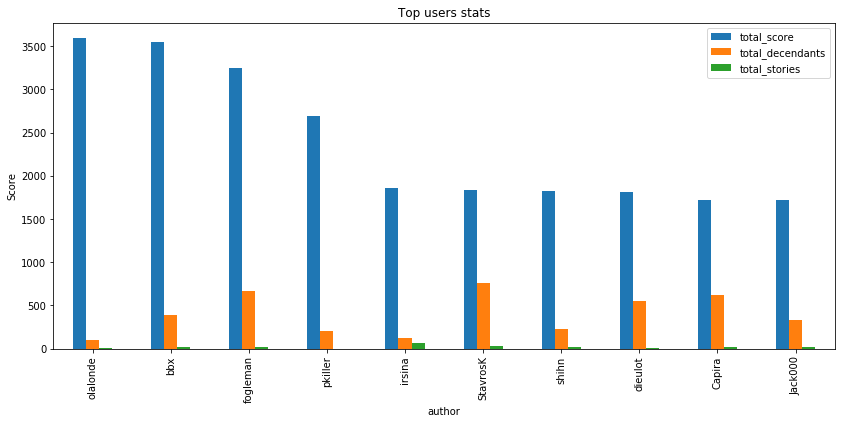

In [0]:
# Transform the rows into a nice pandas dataframe
top_users = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
top_users.fillna(0, inplace=True)
# Look at the first 10 top scores
top_users.sort_values("total_score")[::-1][:10].plot(x="author",y=["total_score", "total_decendants", "total_stories"], 
                                                   kind="bar",figsize=(14,6),
                                                   title='Top users stats').set_ylabel("Score")

Total number of stories

In [0]:
query = """
SELECT 
COUNT(h_full.id) as total_stories
FROM `bigquery-public-data.hacker_news.full` h_full
where REGEXP_CONTAINS(h_full.title, r"(S|s)how HN")
"""

query_job = client.query(query)

iterator = query_job.result(timeout=30)
rows = list(iterator)
count = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

print("Total number of stories {}".format(count.total_stories.values[0]))

Total number of stories 79856


I am curious why the author with maximum score has few descendents

In [0]:
query = """
SELECT 
SUM(h_full.score) as total_score, h_full.by as author,
SUM(h_full.descendants) as total_decendants,
count(h_full.id) as total_stories
FROM `bigquery-public-data.hacker_news.full` h_full
where REGEXP_CONTAINS(h_full.title, r"(S|s)how HN")
GROUP BY author
ORDER BY total_score DESC
LIMIT 30
"""

query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
high_scores = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
high_scores.fillna(0, inplace=True)
# Look at the first top scores
high_scores.head()

,total_score,author,total_decendants,total_stories
0,3593,olalonde,103,8
1,3544,bbx,386,14
2,3243,fogleman,662,20
3,2690,pkiller,210,1
4,1863,irsina,126,66


In [0]:
query = """
SELECT h_full.*
FROM `bigquery-public-data.hacker_news.full` h_full
where REGEXP_CONTAINS(h_full.title, r"(S|s)how HN") and h_full.by = 'olalonde'
"""

query_job = client.query(query)
iterator = query_job.result(timeout=30)
rows = list(iterator)

# Transform the rows into a nice pandas dataframe
high_scores = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
high_scores.fillna(0, inplace=True)
# Look at the first top scores
high_scores.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,"Show HN: I implemented gmaxwell's ""solvency pr...",https://github.com/olalonde/blind-solvency-proof,0,0,olalonde,29,1393431208,2014-02-26 16:13:28+00:00,story,7305752,0,9,0,0
1,Show HN: This up votes itself,http://news.ycombinator.com/vote?for=3742902&d...,0,0,olalonde,3531,1332463239,2012-03-23 00:40:39+00:00,story,3742902,0,82,0,0
2,Show HN: Show HN Chat,https://discord.gg/0piovD3zkjwdotzl,0,0,olalonde,9,1455678881,2016-02-17 03:14:41+00:00,story,11114986,0,3,0,0
3,Show HN: IRC style community for remote hacker...,http://lonehackers.com/,0,0,olalonde,10,1421151341,2015-01-13 12:15:41+00:00,story,8879278,0,7,0,0
4,"Show HN: One package to require coffeescript, ...",https://github.com/olalonde/better-require,0,0,olalonde,1,1351778726,2012-11-01 14:05:26+00:00,story,4727549,0,0,0,0
